In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.misc import imresize as imresize
from scipy.misc import imread as imread
from scipy.misc import imsave as imsave
import os
import glob
import pickle
import warnings
from scipy.ndimage.measurements import label
warnings.filterwarnings("ignore")
## Import deep learning frameworks
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img 
from sklearn.model_selection import train_test_split
from keras.preprocessing import image
from keras.models import Model
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.models import Sequential
from keras.layers.pooling import MaxPooling2D
from keras.layers import Input
import keras
import tensorflow as tf
from keras import backend as K
from keras.optimizers import Adam as adam
from keras.layers import Lambda
from keras.models import model_from_json
%matplotlib inline

Using TensorFlow backend.


## Get test images

In [2]:
# Apply distortion correction to raw images
# Load rawimages
folder = 'test_images/'
image_files = os.listdir(folder)
test_images = []
for i in range(len(image_files)):
    file_name  = os.path.join(folder, image_files[i])
    if file_name.endswith(".jpg"):
        image_file = imread(file_name, False, 'RGB')
        image_file = imresize(image_file, (720, 1280), interp='bilinear')  
        test_images.append(image_file)

In [3]:
test_images = np.array(test_images)
print(test_images.shape)

(7, 720, 1280, 3)


(-0.5, 1279.5, 719.5, -0.5)

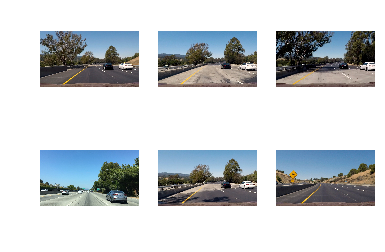

In [4]:
# Visualize Test Images:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6))= plt.subplots(2, 3, sharex='col', sharey='row')

ax1.imshow(test_images[0,:,:,:])
ax1.axis('off')
ax2.imshow(test_images[1,:,:,:])
ax2.axis('off')
ax3.imshow(test_images[2,:,:,:])
ax3.axis('off')
ax4.imshow(test_images[3,:,:,:])
ax4.axis('off')
ax5.imshow(test_images[4,:,:,:])
ax5.axis('off')
ax6.imshow(test_images[6,:,:,:])
ax6.axis('off')

In [5]:
## Keep only the region, where the vechile is more likely.
cut_test_images = []

for i in range(len(test_images)):
    cut_test = test_images[i, 380:, :, :]
    cut_test_images.append(cut_test)

cut_test_images = np.array(cut_test_images)
print(cut_test_images.shape)

(7, 340, 1280, 3)


(-0.5, 1279.5, 339.5, -0.5)

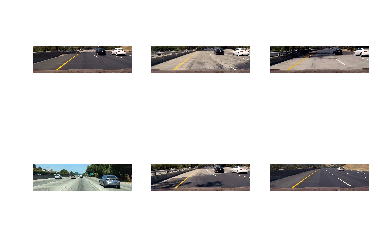

In [6]:
# Visualize Test Images:
f, ((ax1, ax2, ax3), (ax4, ax5, ax6))= plt.subplots(2, 3, sharex='col', sharey='row')

ax1.imshow(cut_test_images[0,:,:,:])
ax1.axis('off')
ax2.imshow(cut_test_images[1,:,:,:])
ax2.axis('off')
ax3.imshow(cut_test_images[2,:,:,:])
ax3.axis('off')
ax4.imshow(cut_test_images[3,:,:,:])
ax4.axis('off')
ax5.imshow(cut_test_images[4,:,:,:])
ax5.axis('off')
ax6.imshow(cut_test_images[5,:,:,:])
ax6.axis('off')

## Data Curation:

In [7]:
data_dict = pickle.load(open( "dataset.p", "rb" ))
car_list = data_dict["cars"]
notcar_list = data_dict["n_cars"]
car_list = np.array(car_list)
notcar_list = np.array(notcar_list)
print('Training set of cars: ', car_list.shape)
print('Training set of not-cars:', notcar_list.shape)

Training set of cars:  (8792, 64, 64, 3)
Training set of not-cars: (8968, 64, 64, 3)


In [8]:
## Data setup:

# Create an array stack of feature vectors
X = np.vstack((car_list, notcar_list)).astype(np.float64)                        

# Define the labels vector
y = np.hstack((np.ones(len(car_list)), np.zeros(len(notcar_list))))

print('Training Images: ', X.shape)
print('Training Label : ', y.shape)

Training Images:  (17760, 64, 64, 3)
Training Label :  (17760,)


In [9]:
def data_augement(dataX, dataY):
    
    dataX_return = np.zeros((dataX.shape[0], 64, 64,3))
    dataY_return = np.zeros((dataY.shape[0]))
    
    datagen = ImageDataGenerator(rotation_range=0,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=False,
                                fill_mode='nearest')
    
    for i in range(dataX.shape[0]):
        
        x = img_to_array(dataX[i,:,:,:])
        x = x.reshape((1,) + x.shape)
        
        dataY_return[i] = dataY[i]
        
        for batch in datagen.flow(x, batch_size = 1):
            dataX_return[i,:,:,:] = batch
            break
            
    # Concatenate the original data with augmented data
    datax = np.concatenate((dataX, dataX_return), axis = 0)
    datay = np.concatenate((dataY, dataY_return), axis = 0)
    
    return datax, datay

In [10]:
#Generate data additional data using training dataset
x_aug, y_aug = data_augement(X, y)

In [11]:
print('Training Images: ', x_aug.shape)
print('Training Label : ', y_aug.shape)

Training Images:  (35520, 64, 64, 3)
Training Label :  (35520,)


In [12]:
def DNN():
    # Start
    model = Sequential()
    # set up lambda layer
    model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(64,64,3)))
    # Apply a 5x5 convolution with 24 output filters on a 31x98 image:
    model.add(Convolution2D(24, 5, 5, subsample=(2, 2), border_mode='valid', name='cnn1')) 
    # Add a 5x5 convolution on top, with 36 output filters:
    model.add(Convolution2D(36, 5, 5, subsample=(2, 2), border_mode='valid', name='cnn2'))
    # Add a 5x5 convolution on top, with 48 output filters:
    model.add(Convolution2D(54, 5, 5, subsample=(2, 2), border_mode='valid', name='cnn3'))
    # Add a 3x3 convolution on top, with 64 output filters:
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode='valid', name='cnn4'))
    # Add a 3x3 convolution on top, with 64 output filters:
    model.add(Convolution2D(64, 3, 3, subsample=(1, 1), border_mode='valid', name='cnn5'))
    # Flatten
    model.add(Flatten())
    # Fully-Connected Layer -1
    model.add(Dense(1164, name='fc1'))
    # Activation
    model.add(Activation('relu'))
    # Fully-Connected Layer -2
    model.add(Dense(100, name='fc2'))
    # Activation
    model.add(Activation('relu'))
    # Fully-Connected Layer -3
    model.add(Dense(50, name='fc3'))
    # Activation
    model.add(Activation('relu'))
    # Dropout
    model.add(Dropout(0.5))
    # Fully-Connected Layer -4
    model.add(Dense(10, name='fc4'))
    # Activation
    model.add(Activation('relu'))
    # Output Layer
    model.add(Dense(1, name='fc5'))
    
    return model

In [13]:
model = DNN()
adm = adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=adm, loss='mse')
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_1 (Lambda)                (None, 64, 64, 3)     0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
cnn1 (Convolution2D)             (None, 30, 30, 24)    1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
cnn2 (Convolution2D)             (None, 13, 13, 36)    21636       cnn1[0][0]                       
____________________________________________________________________________________________________
cnn3 (Convolution2D)             (None, 5, 5, 54)      48654       cnn2[0][0]                       
___________________________________________________________________________________________

In [15]:
model.fit(x_aug, y_aug, batch_size=128, nb_epoch=5, validation_split=0.2, shuffle=True)

json_string = model.to_json()

with open("model.json", "w") as json_file:
    json_file.write(json_string)

print("DNN architecture Saved,")

model.save_weights('model.h5')
print("Weights Saved.")

Train on 28416 samples, validate on 7104 samples
Epoch 1/5
28416/28416 [==============================] - 6s - loss: 0.0708 - val_loss: 0.0470

## Prediction

In [5]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

# Load model
model = model_from_json(loaded_model_json)

# compile the model
model.compile(optimizer='adam', loss='mse')

# load weights into new model
model.load_weights("model.h5", by_name=True)
print("Loaded model from disk")

Loaded model from disk


In [6]:
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    
    warnings.simplefilter("ignore")
    
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
            
    # Return the list of windows
    return window_list

In [7]:
# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    
    for window in windows:
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        test_img = np.array(test_img)
        test_img = np.reshape(test_img, (1,64,64,3))
            
        prediction = model.predict(test_img, batch_size=1)
        
        if prediction >= 0.8:
            # Append window position to list
            on_windows.append(window)
    
    #8) Return windows for positive detections
    return on_windows

In [8]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [9]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [10]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

In [11]:
def final_output(image, hot_windows):
    box_list = hot_windows
    
    # Read in image similar to one shown above 
    heat  = np.zeros_like(image[:,:,0]).astype(np.float)

    # Add heat to each box in box list
    heat = add_heat(heat,box_list)

    # Apply threshold to help remove false positives
    heat1 = apply_threshold(heat,0.7)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat1, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(image), labels)
    
    return draw_img, heatmap

In [12]:
image = test_images[1]
draw_image = np.copy(image)

In [13]:
# Sliding window of different sizes.
windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 580], 
                xy_window=(64, 64), xy_overlap=(0.5, 0.5))
windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[480, 680], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[480, 720], 
                    xy_window=(256, 256), xy_overlap=(0.5, 0.5))

In [14]:
windows = []

windows.extend(windows1)
windows.extend(windows2)
windows.extend(windows3)

In [15]:
hot_windows = search_windows(image, windows)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)

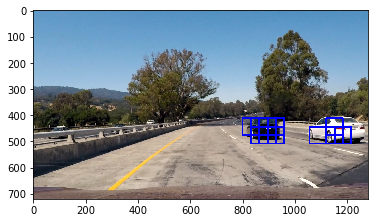

In [16]:
plt.imshow(window_img)

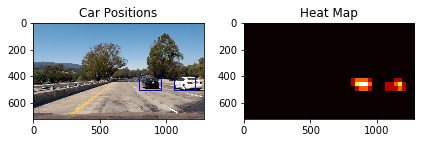

In [17]:
draw_img, heatmap = final_output(draw_image, hot_windows)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

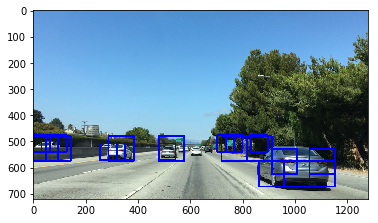

In [21]:
image = test_images[3]
draw_image = np.copy(image)

windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 580], 
                xy_window=(64, 64), xy_overlap=(0.5, 0.5))
windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[480, 680], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[480, 720], 
                    xy_window=(256, 256), xy_overlap=(0.5, 0.5))
windows = []
windows.extend(windows1)
windows.extend(windows2)
windows.extend(windows3)

hot_windows = search_windows(image, windows)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
plt.imshow(window_img)

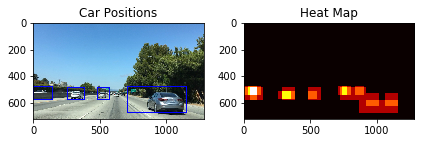

In [22]:
draw_img, heatmap = final_output(draw_image, hot_windows)

fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

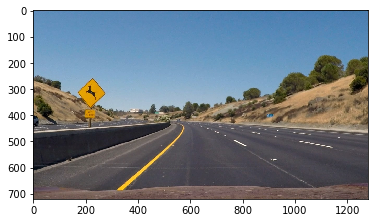

In [23]:
image =  test_images[6]
draw_image = np.copy(image)

windows1 = slide_window(image, x_start_stop=[None, None], y_start_stop=[380, 580], 
                xy_window=(64, 64), xy_overlap=(0.5, 0.5))
windows2 = slide_window(image, x_start_stop=[None, None], y_start_stop=[480, 680], 
                    xy_window=(96, 96), xy_overlap=(0.5, 0.5))
windows3 = slide_window(image, x_start_stop=[None, None], y_start_stop=[480, 720], 
                    xy_window=(256, 256), xy_overlap=(0.5, 0.5))
windows = []
windows.extend(windows1)
windows.extend(windows2)
windows.extend(windows3)

hot_windows = search_windows(image, windows)
window_img = draw_boxes(draw_image, hot_windows, color=(0, 0, 255), thick=6)
plt.imshow(window_img)